# Surrogate analysis for the daily mean LST at all points

## Setting up

### Import packages here

In [6]:
import pickle
from xarray import open_dataset
from numpy import (sqrt, append, isnan, datetime64, arange, linspace, zeros, sum, array, dot, stack
    ,maximum, minimum, fmax, fmin, ceil, sign)
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colorbar, colors

# some parameters
plt.rcParams.update({'font.size': 14})

In [7]:
from wrf_fvcom.variables import (
    WRF_PBL_SFCLAY, WRF_WaterZ0, WRF_MP, WRF_RA, WRF_LM,
    FVCOM_Prandtl, FVCOM_SWRadiationAbsorption,
    FVCOM_VerticalMixing, FVCOM_WindStress,
)
from wrf_fvcom.perturb import (
    transform_perturbation_matrix,
)
from surrogate.nn_regression import make_nn_surrogate_model
from surrogate.pc_regression import make_pc_surrogate_model
from surrogate.utils import surrogate_model_predict
from surrogate.gsa import compute_sensitivities, plot_sens

### Set the variables to analyze and get list of filenames

In [8]:
# time start and end 
ts = datetime64('2018-06-01')
te = datetime64('2018-09-01')

# choose variables want to analyze..
variables = [WRF_PBL_SFCLAY,
             WRF_MP, 
             WRF_RA,
             WRF_WaterZ0,
             WRF_LM,
             FVCOM_VerticalMixing,
             FVCOM_WindStress,
             FVCOM_Prandtl,
             FVCOM_SWRadiationAbsorption,
            ]

# get the variable names as a list
variable_names = [variable.name for variable in variables]

# test set does not have WRF_LM inside
variable_names_test = [variable.name for variable in variables if variable is not WRF_LM]
no_name_I = [4]
test_run_I = [0,2,4,5,8]

In [9]:
#filenames
train_parameters_file = '../output/perturbation_matrix_9variables_korobov18.nc'
test_parameters_file = '../output/perturbation_matrix_8variables_korobov19.nc'
train_output_filename = '../output/wfv_global_daily_temperature_training_set.pkl'
test_output_filename = '../output/wfv_global_daily_temperature_test_set.pkl'

#surrogate output filename
surrogate_output_filename = '../output/LST_klsurrogate_models.pkl'

## Load inputs 

In [10]:
## parameter info

# Get parameter training range and ensemble
params = open_dataset(train_parameters_file)
pnames = params.sel(variable=variable_names).variable.values
ptrain = params.sel(variable=variable_names).perturbation_matrix

# transform the input matrix
variable_matrix_train = transform_perturbation_matrix(ptrain)

In [11]:
# Get parameter test range and ensemble
params_t = open_dataset(test_parameters_file)
pnames_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).variable.values

# combining both sets of runs
ptest_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).perturbation_matrix
#
# transform into same variable number as train set and put value of 1 for Land Model
ptest = ptrain.isel(run=test_run_I)
ptest[:,[idx for idx, var_name in enumerate(variable_names) if idx not in no_name_I]] = ptest_t.values
ptest[:,no_name_I] = 1

# transform the input matrix
variable_matrix_test_t = transform_perturbation_matrix(ptest)
# transform into same scheme number as train set and put value of 0 where doesn't exist
variable_matrix_test = variable_matrix_train.isel(run=test_run_I)
scheme_names = variable_matrix_test['scheme'].values
no_scheme_I = [idx for idx, scheme_name in enumerate(scheme_names)
               if scheme_name not in variable_matrix_test_t['scheme'].values]
variable_matrix_test[:,[idx for idx, scheme_name in enumerate(scheme_names) if idx not in no_scheme_I]] = \
    variable_matrix_test_t.values
variable_matrix_test[:,no_scheme_I] = 0

In [12]:
## data info

#load the training data
with open(train_output_filename, 'rb') as fp:
    train_dict = pickle.load(fp)
    print('Done loading training data from binary file')
    
with open(test_output_filename, 'rb') as fp:
    test_dict = pickle.load(fp)
    print('Done loading test data from binary file')

Done loading training data from binary file
Done loading test data from binary file


In [13]:
# Get and check train sizes
nens = len(train_dict['runs'])
ntime = train_dict['LST'][0][0].shape[0]
ntime_, ngrid = train_dict['LST'][0][1].shape
nens_ = len(train_dict['LST'])
nens__, ndim = variable_matrix_train.shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Training set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'Timeseries size : {ntime}')
print(f'Spatial size: {ngrid}')

nens_train = nens

Training set info:
Ensembles size : 18
Parameter dim : 20
Timeseries size : 112
Spatial size: 35749


In [14]:
# Get and check test sizes
nens = len(test_dict['runs'])
ntime = test_dict['LST'][0][0].shape[0]
ntime_, ngrid = test_dict['LST'][0][1].shape
nens_ = len(test_dict['LST'])
nens__, ndim = variable_matrix_test.shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Test set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'Timeseries size : {ntime}')
print(f'Spatial size: {ngrid}')

nens_test = nens

Test set info:
Ensembles size : 5
Parameter dim : 20
Timeseries size : 112
Spatial size: 35749


In [15]:
# construct the training data into right dimensions
for rdx, run in enumerate(train_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2 = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        trainY = value_temp
    else:
        trainY = append(trainY,value_temp,axis=0)
display(trainY.shape)
        
# construct the training data into right dimensions
for rdx, run in enumerate(test_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2_ = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        testY = value_temp
    else:
        testY = append(testY,value_temp,axis=0)
        
display(testY.shape)

(18, 3288908)

(5, 3288908)

## Decompose the time series

In [16]:
# some variables for surrogate
var_explained = len(variables) #for PCA

# randomization
random_seeds = range(111,999+111,111)
#seed = 666 # val_loss = 0.71 , BO gives ??
#seed = 111 # val_loss = 0.67,  BO gives BO1 parameters
#seed = 99 # val_loss = 0.73 , BO gives BO1 except COARE, GOTM k-eps
#seed = 222 # val_loss = 0.66, BO gives BO1 except COARE, GOTM k-eps
#seed = None

In [17]:
# Decompose the spatiotemporal series using PCA/KL
pca_obj = PCA(n_components=var_explained, 
              random_state=random_seeds[0], 
              whiten=True)
pca_obj.fit(trainY)

PCA(n_components=9, random_state=111, whiten=True)

In [18]:
# get the outputs from the PCA
klxi_train = pca_obj.transform(trainY)
klxi_test  = pca_obj.transform(testY)
eigenratio = pca_obj.explained_variance_ratio_
print(eigenratio)
print(eigenratio.sum())
neig = pca_obj.n_components_
eigenvalues = pca_obj.explained_variance_
eigenmodes = pca_obj.components_
mean_vector = pca_obj.mean_
print(f'number of eigenmodes is {neig}')

[0.59524146 0.10616204 0.04990378 0.04276877 0.03184092 0.0306296
 0.02111236 0.0180193  0.01771278]
0.9133910082750212
number of eigenmodes is 9


In [19]:
# Check the error of PCA for test is similar to train
print(f'PCA train mean abs error: {(abs(pca_obj.inverse_transform(klxi_train) - trainY)).mean()}')
print(f'PCA test mean abs error: {(abs(pca_obj.inverse_transform(klxi_test) - testY)).mean()}')

PCA train mean abs error: 0.19694867240824765
PCA test mean abs error: 0.37530686991760287


In [20]:
print(f'PCA train std error: {(pca_obj.inverse_transform(klxi_train) - trainY).std()}')
print(f'PCA test std error: {(pca_obj.inverse_transform(klxi_test) - testY).std()}')

PCA train std error: 0.2705900326792565
PCA test std error: 0.5217007675333669


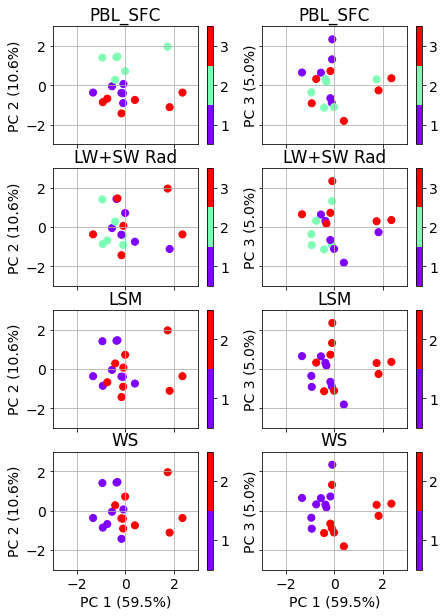

In [25]:
labels = [
    f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(eigenratio * 100)
]
important_variables = [WRF_PBL_SFCLAY, WRF_RA, WRF_LM, FVCOM_WindStress]
pname_paper = ['PBL_SFC', 'LW+SW Rad', 'LSM', 'WS']
bnds = 3

fig, axs = plt.subplots(len(important_variables), 2,sharey=True,sharex=True,figsize=(7,10))
for vv,var in enumerate(important_variables):
    cat = ptrain.sel(variable=var.name).values
    cmap = plt.cm.rainbow
    catrange = arange(cat.min()-0.5, cat.max()+1.5, 1)
    norm = colors.BoundaryNorm(catrange, cmap.N)
    for ii in [0,1]:
        py = axs[vv,ii].scatter(klxi_train[:,0],klxi_train[:,ii+1],s=50,c=cat, cmap=cmap, norm=norm)
        if vv == len(important_variables)-1:
            axs[vv,ii].set_xlabel(labels[0])
        axs[vv,ii].set_ylabel(labels[ii+1])
        axs[vv,ii].grid()
        axs[vv,ii].set_xlim([-bnds,bnds])
        axs[vv,ii].set_ylim([-bnds,bnds])
        plt.colorbar(py,ax=axs[vv,ii],ticks=catrange+0.5)
        axs[vv,ii].set_title(pname_paper[vv])
#plt.suptitle('LST mode categorization')
plt.subplots_adjust(wspace=0.15)

plt.savefig('../figures/LST_mode_categorization',dpi=600,bbox_inches='tight')
plt.show()

##  Construct surrogate models

In [18]:
# using hot_enconding or not
hot_encode = True
# setup training and test inputs based on onehotencoding or not
if hot_encode:
    train_x = variable_matrix_train
    test_x = variable_matrix_test
else:
    train_x = ptrain
    test_x = ptest

# PC surrogate model parameters
polynomial_order = 2
regression_type = 'ElasticNet'

# NN surrogate model parameters
batch_size = nens_train // 3 #5 K-Fold
npl_hi = int((neig + ndim)/2+1)
hidden_layers = [npl_hi,npl_hi] #[npl_hi,int((npl_hi + neig)/2+1),neig+1] #[npl_hi,neig+1] 
learn_rate = 0.001
do = learn_rate
nepochs=2000 #10000
nepochs_cv=2000

#npls = range(len(variables)+1,npl_hi+1)
#dropouts = [0.125,0.15,0.175,0.2]

# cross-validation settings
n_folds = 5 #number k folds

In [19]:
# initialize the surrogate dictionary
kl_surrogate = dict()

### Train and check the PC model

In [20]:
# Polynomial Chaos
kl_surrogate['PC'] = list()
for random_seed in random_seeds:
    print(random_seed)
    kl_surrogate['PC'].append(
        make_pc_surrogate_model(
        train_x, klxi_train, polynomial_order=polynomial_order, regressor=regression_type,
        cv=KFold(n_splits=n_folds, shuffle=True, random_state=random_seed),
        )
    )

111


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.577e-03, tolerance: 1.700e-03
  model = cd_fast.enet_coordinate_descent(


222


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


333


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


444


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.852e-03, tolerance: 1.700e-03
  model = cd_fast.enet_coordinate_descent(


555


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


666


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


777


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


888


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


999


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.577e-03, tolerance: 1.700e-03
  model = cd_fast.enet_coordinate_descent(


### Train and check the NN model

111
Using [15, 15] hidden layer structure
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.356118   0.374565   0.373390     0.373390(0)   0.001000
      2000       6000   0.000236   0.000161   0.002438     0.000019(1930)   0.001000


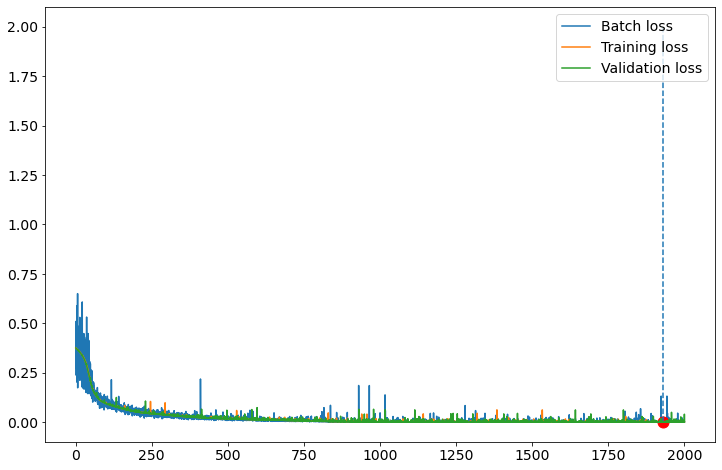

222
Using [15, 15] hidden layer structure
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.322298   0.360926   0.359525     0.359525(0)   0.001000
      2000       6000   0.000232   0.000270   0.000155     0.000018(1877)   0.001000


<Figure size 432x288 with 0 Axes>

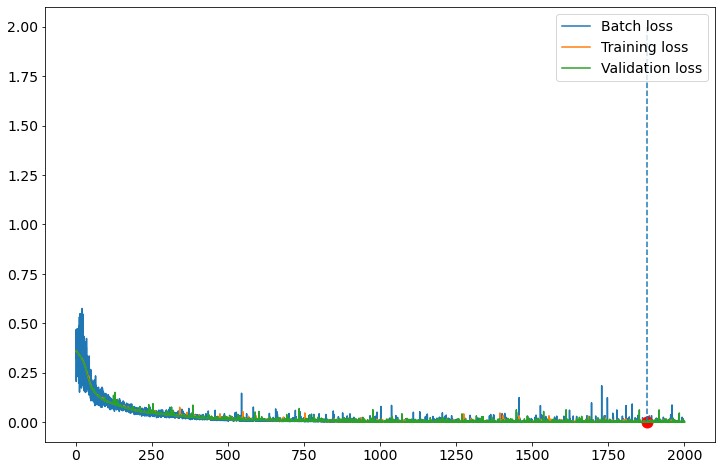

333
Using [15, 15] hidden layer structure
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.365206   0.368246   0.364106     0.364106(0)   0.001000
      2000       6000   0.000063   0.000044   0.000300     0.000011(1906)   0.001000


<Figure size 432x288 with 0 Axes>

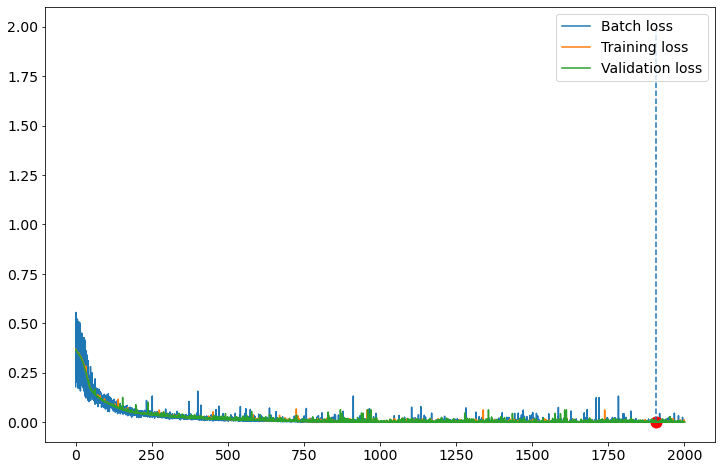

444
Using [15, 15] hidden layer structure
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.166881   0.372578   0.370568     0.370568(0)   0.001000
      2000       6000   0.000040   0.000041   0.000096     0.000029(1953)   0.001000


<Figure size 432x288 with 0 Axes>

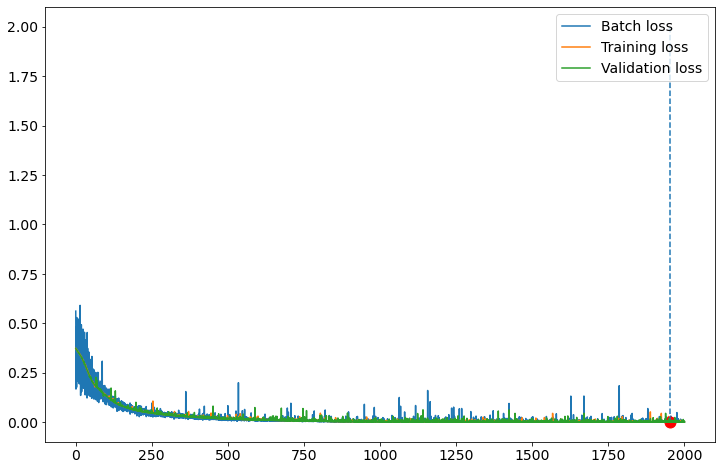

555
Using [15, 15] hidden layer structure
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.364580   0.359239   0.358503     0.358503(0)   0.001000
      2000       6000   0.000150   0.000101   0.000201     0.000033(1982)   0.001000


<Figure size 432x288 with 0 Axes>

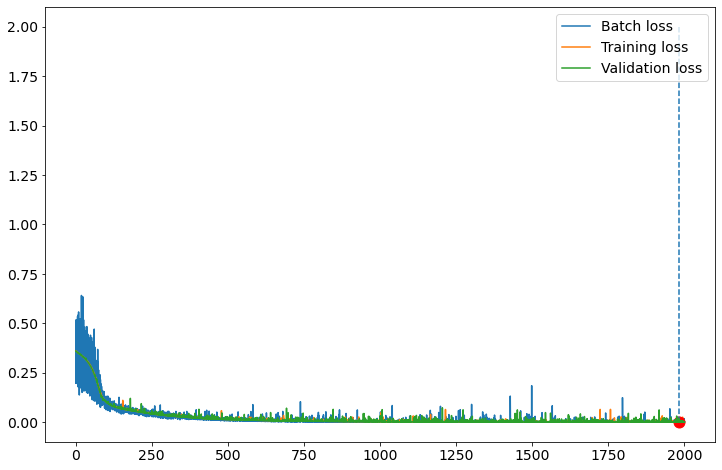

666
Using [15, 15] hidden layer structure
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.484527   0.369493   0.368667     0.368667(0)   0.001000
      2000       6000   0.003685   0.000896   0.010762     0.000808(1999)   0.001000


<Figure size 432x288 with 0 Axes>

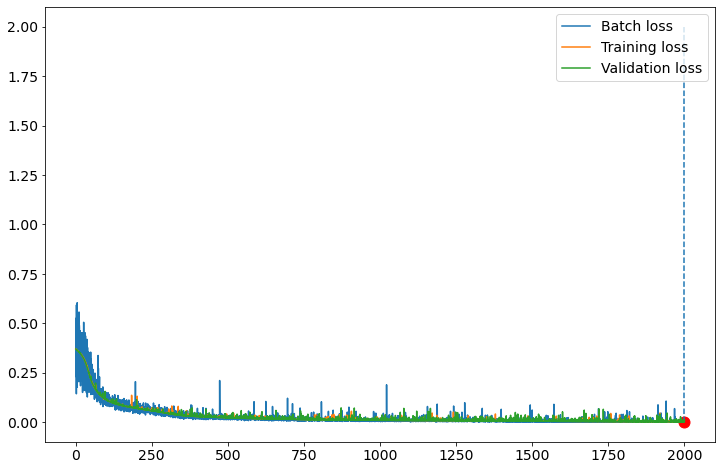

777
Using [15, 15] hidden layer structure
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.174794   0.355708   0.354513     0.354513(0)   0.001000
      2000       6000   0.000364   0.006234   0.004367     0.000007(1946)   0.001000


<Figure size 432x288 with 0 Axes>

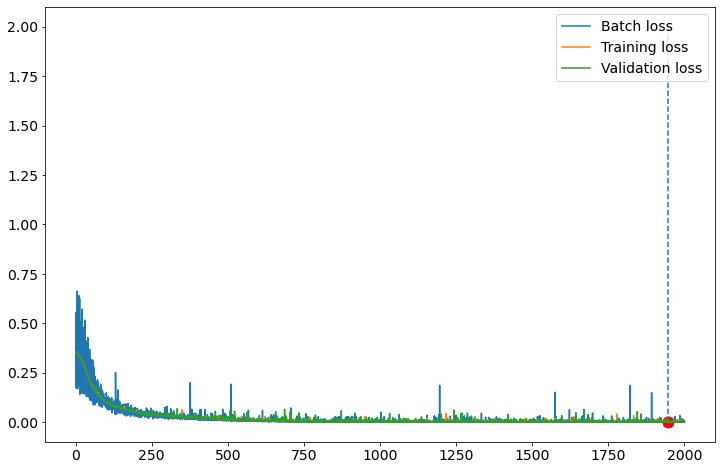

888
Using [15, 15] hidden layer structure
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.295839   0.381192   0.378509     0.378509(0)   0.001000
      2000       6000   0.000114   0.000186   0.000209     0.000186(1999)   0.001000


<Figure size 432x288 with 0 Axes>

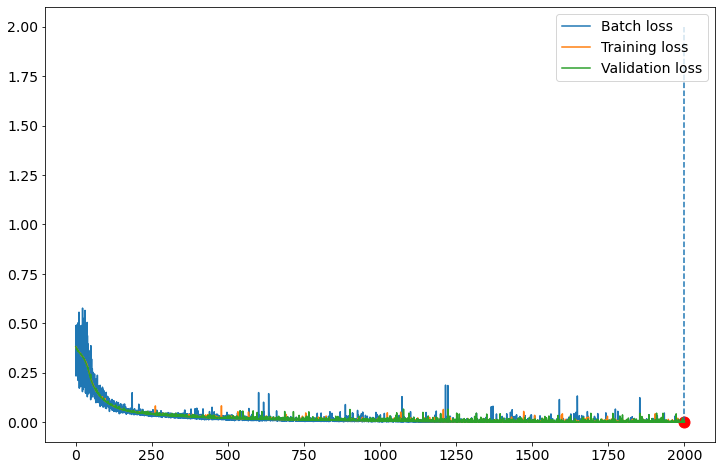

999
Using [15, 15] hidden layer structure
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.354946   0.349413   0.348267     0.348267(0)   0.001000
      2000       6000   0.000066   0.000082   0.000101     0.000071(1979)   0.001000


<Figure size 432x288 with 0 Axes>

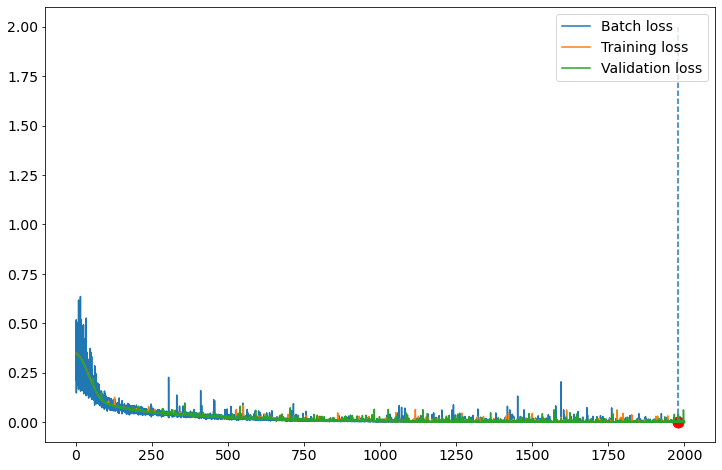

<Figure size 432x288 with 0 Axes>

In [21]:
# Neural Network
kl_surrogate['NN'] = list()
for random_seed in random_seeds:
    print(random_seed)
    #loss = 1e6
    #for npl in npls:
    #    print(f'npl = {npl}')
    ##    for do in dropouts:
    ##        print(f'dropout = {do}')
    #    klnn_temp = make_nn_surrogate_model(
    #        train_x.values, klxi_train.astype(float),
    #        #cv=ShuffleSplit(n_splits=5,test_size=5,random_state=random_seed), 
    #        cv=KFold(n_splits=n_folds, shuffle=True, random_state=random_seed),  
    #        num_hidden_layers=hidden_layers,
    #        neurons_per_layer=npl,
    #        lrate=learn_rate,
    #        batch_size=batch_size,
    #        nepochs=nepochs_cv,
    #       seed=random_seed,
    #        eigenratio=eigenratio,
    #        dropout=do,
    #        freq_out=1e6,
    #        freq_plot=1e6,
    #    )
    #   loss_temp = sum([sur.best_loss for sur in klnn_temp])
    #    if loss_temp < loss:
    #        npl_best = npl
    #        #do_best = do
    #        loss = loss_temp
    #
    #print(f'best npl = {npl_best}')
    #print(f'best dropout = {do_best}')
    
    kl_surrogate['NN'].append(
        make_nn_surrogate_model(
            train_x.values, klxi_train.astype(float),
            hidden_layers=hidden_layers,
            lrate=learn_rate,
            batch_size=batch_size,
            nepochs=nepochs,
            seed=random_seed,
            loss='huber',
            activ='relu',
            eigenratio=eigenratio,
            dropout=do,
            freq_out=1e6,
            freq_plot=1e6,
        )
    )

In [22]:
# save into pickle file
with open(surrogate_output_filename, 'wb') as fp:
    pickle.dump(kl_surrogate, fp)
    print('Written surrogate models into the output binary file')

Written surrogate models into the output binary file


##  Assess the surrogate model accuracy

poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)


(a) training
NN MSE_w stats
0.006233659879029003
0.016421636839244295
PC MSE_w stats
0.10436748627242805
0.04123588376730435


poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)


(b) test
NN MSE_w stats
0.7289774118075605
0.15629274631139972
PC MSE_w stats
0.6838009799532432
0.04204896770705515


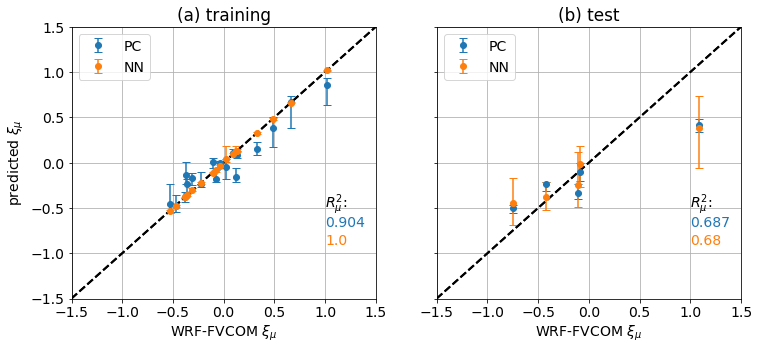

In [23]:
# Checking PC and NN accuracy for sqrt(eigenvalue)-weighted combined
rmse_v = 2
r2_v = -0.5
bnds = 1.5

fig, axs = plt.subplots(1, 2,sharey=True,figsize=(12,5))

for ii in [0,1]:
    
    if ii == 0:
        comparison = '(a) training'
        klxi_model = klxi_train
        # pc
        for ss, sur in enumerate(kl_surrogate['PC']):
            klxi_pred = surrogate_model_predict(sur,train_x)
            if ss == 0:
                klxi_preds0 = klxi_pred[None,:,:]
            else:
                klxi_preds0 = append(klxi_preds0,klxi_pred[None,:,:],axis=0)
        #klxi_pred0 = surrogate_model_predict(kl_surrogate['PC'],train_x)
        # nn
        for ss, sur in enumerate(kl_surrogate['NN']):
            klxi_pred = surrogate_model_predict(sur,train_x.values)
            if ss == 0:
                klxi_preds = klxi_pred[None,:,:]
            else:
                klxi_preds = append(klxi_preds,klxi_pred[None,:,:],axis=0)
        #klxi_pred = surrogate_model_predict(kl_surrogate['NN'],train_x.values)
        #zeros(klxi_model.shape)
        #n_folds = len(kl_surrogate['NN'])
        #for fold_surrogate in kl_surrogate['NN']:
        #    klxi_pred += surrogate_model_predict(fold_surrogate,train_x.values)
        #klxi_pred = klxi_pred / n_folds
    else:
        comparison = '(b) test'
        
        klxi_model = klxi_test
        # pc
        for ss, sur in enumerate(kl_surrogate['PC']):
            klxi_pred = surrogate_model_predict(sur,test_x)
            if ss == 0:
                klxi_preds0 = klxi_pred[None,:,:]
            else:
                klxi_preds0 = append(klxi_preds0,klxi_pred[None,:,:],axis=0)
        #klxi_pred0 = surrogate_model_predict(kl_surrogate['PC'],test_x)
        # nn
        for ss, sur in enumerate(kl_surrogate['NN']):
            klxi_pred = surrogate_model_predict(sur,test_x.values)
            if ss == 0:
                klxi_preds = klxi_pred[None,:,:]
            else:
                klxi_preds = append(klxi_preds,klxi_pred[None,:,:],axis=0)
        #klxi_pred = surrogate_model_predict(kl_surrogate['NN'],test_x.values)
        #klxi_pred = zeros(klxi_model.shape)
        #n_folds = len(kl_surrogate['NN'])
        #for fold_surrogate in kl_surrogate['NN']:
        #    klxi_pred += surrogate_model_predict(fold_surrogate,test_x.values)
        #klxi_pred = klxi_pred / n_folds
        
    #klxi_pred0 = klxi_preds0.mean(axis=0)
    #klxi_errorbars0 = abs(stack((klxi_preds0.min(axis=0),klxi_preds0.max(axis=0))) - klxi_pred0)
    #klxi_pred = klxi_preds.mean(axis=0)
    #klxi_errorbars = abs(stack((klxi_preds.min(axis=0),klxi_preds.max(axis=0))) - klxi_pred)
    
    model_w = (sqrt(eigenvalues)*klxi_model).sum(axis=1)/sqrt(eigenvalues).sum()
    pred_w = {'NN':  zeros(klxi_preds[:,:,0].shape),
              'PC':  zeros(klxi_preds0[:,:,0].shape)}
    mse_w = {'NN':  zeros(klxi_preds[:,:,0].shape[0]),
            'PC':  zeros(klxi_preds0[:,:,0].shape[0])}
    for ss,klxi_pred in enumerate(klxi_preds):
        pred_w['NN'][ss,:] = (sqrt(eigenvalues)*klxi_pred).sum(axis=1)/sqrt(eigenvalues).sum()
        mse_w['NN'][ss] = ((eigenvalues*(klxi_pred - klxi_model)**2).sum(axis=1)/eigenvalues.sum()).mean()
    for ss,klxi_pred0 in enumerate(klxi_preds0):
        pred_w['PC'][ss,:] = (sqrt(eigenvalues)*klxi_pred0).sum(axis=1)/sqrt(eigenvalues).sum()
        mse_w['PC'][ss] = ((eigenvalues*(klxi_pred0 - klxi_model)**2).sum(axis=1)/eigenvalues.sum()).mean()
    
    print(comparison)
    print('NN MSE_w stats')
    print(mse_w['NN'].mean())
    print(mse_w['NN'].std())
    print('PC MSE_w stats')
    print(mse_w['PC'].mean())
    print(mse_w['PC'].std())
    
    axs[ii].text(bnds-0.5,r2_v,'$R^2_\mu$:')
    for st,surrogate_type in enumerate(['PC','NN']):
        pred_wm = pred_w[surrogate_type].mean(axis=0)
        pred_werror = abs(stack((pred_w[surrogate_type].min(axis=0),
                                 pred_w[surrogate_type].max(axis=0))) - pred_wm)
        py = axs[ii].errorbar(model_w, pred_wm,
                              yerr=pred_werror,
                              fmt='o',
                              capsize=4,
                              label=surrogate_type)
        u = ((model_w - pred_wm)**2).sum()
        v = ((model_w - model_w.mean())**2).sum()
        r2 = 1 - u/v
        axs[ii].text(bnds-0.5,r2_v-(1+st)*0.2,str(round(r2,3)),color=py[0].get_color())
        axs[ii].plot([-bnds,bnds], [-bnds,bnds], 'k--', lw=2)
    axs[ii].set_xlabel(r'WRF-FVCOM $\xi_\mu$')
    if ii == 0:
        axs[ii].set_ylabel(r'predicted $\xi_\mu$')
    axs[ii].set_xlim([-bnds,bnds])
    axs[ii].set_ylim([-bnds,bnds])
    axs[ii].set_title(f'{comparison}')
    axs[ii].legend(loc='upper left')
    axs[ii].grid()
plt.show()